In [1]:
import numpy as np
from scipy import constants as cst
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z],
    [couplings.polarization_X, couplings.polarization_Y],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0="Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0=1 * hamiltonian.Γ,  # Rabi frequency of the laser [rad/s]
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # J=1 -> J=2 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1.56e6,  # polarization switching frequency [rad/s]
    φ1=0.0,  # polarization switching phase [rad]
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
)

In [5]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=3,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [6]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system, transition_selectors, odepars
)

In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.484129
"|X, J = 2>",0.515871


In [8]:
couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0, F₁ = 1/2, F = 0>",0.336756
"|X, J = 0, F₁ = 1/2, F = 1>",0.147373
"|X, J = 2, F₁ = 3/2, F = 1>",0.100763
"|X, J = 2, F₁ = 3/2, F = 2>",0.026135
"|X, J = 2, F₁ = 5/2, F = 2>",0.388973


In [9]:
from typing import Sequence, Optional
import numpy.typing as npt
from centrex_tlf.utils.population import thermal_population, J_levels


def generate_thermal_population_states(
    temperature: float,
    QN: Sequence[states.State],
    select: Optional[states.QuantumSelector] = None,
) -> npt.NDArray[np.complex_]:
    levels = len(QN)
    ρ = np.zeros([levels, levels], dtype=complex)

    assert isinstance(QN[0], states.State), "no State objects supplies"

    if select is not None:
        j_levels = np.unique(select.J)
    else:
        j_levels = np.unique(
            [
                qn.largest.J
                for qn in QN
                if qn.largest.electronic_state == states.ElectronicState.X
            ]
        )

    # get the relative thermal population fractions of the ground state
    population = dict(
        [(j, p) for j, p in zip(j_levels, thermal_population(j_levels, temperature))]
    )

    # # get quantum numbers of the ground state
    # quantum_numbers = [
    #     (qn.largest.J, qn.largest.F1, qn.largest.F, qn.largest.mF)
    #     for qn in QN
    #     if qn.largest.electronic_state == states.ElectronicState.X
    # ]

    # assert len(np.unique(quantum_numbers, axis=0)) == len(
    #     quantum_numbers
    # ), "duplicate quantum numbers"

    for idx, qn in enumerate(QN):
        if qn.largest.electronic_state is not states.ElectronicState.X:
            continue
        elif qn.largest.F is None:
            ρ[idx, idx] = population[qn.largest.J]
        else:
            ρ[idx, idx] = population[qn.largest.J] / J_levels(qn.largest.J)

    return ρ

## Calculate rabi rates and population density

In [10]:
ρ = generate_thermal_population_states(
    temperature=6.3,
    QN=obe_system.QN,
)
ρ /= np.trace(ρ)

In [11]:
power = 85e-3  # * 11 / 2  # 11 passes assume zero intensity left after 11 passes
intensity = power / (25.4e-3 * 25.4e-3)
rabi = utils.rabi.intensity_to_rabi(
    intensity, obe_system.couplings[0].main_coupling, D=2.6675506e-30
).real

rabi_microwave_12 = utils.rabi.power_to_rabi_gaussian_beam_microwave(
    power=200e-3,
    coupling=obe_system.couplings[1].main_coupling,
    sigma_x=25.4e-3,
    sigma_y=25.4e-3,
).real

## J12 microwave on

In [40]:
odepars.Ωl0 = rabi
odepars.Ω1 = rabi_microwave_12
odepars.ω1 = 2 * np.pi * 1.56e6

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz))
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)

In [41]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [42]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

In [43]:
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [44]:
import copy

res = copy.deepcopy(results)

res.y[indices_J2[0], :] = res.y[indices_J2].mean(axis=0)
res.y = np.delete(res.y, obj=indices_J2[1:], axis=0)

0.94 photons


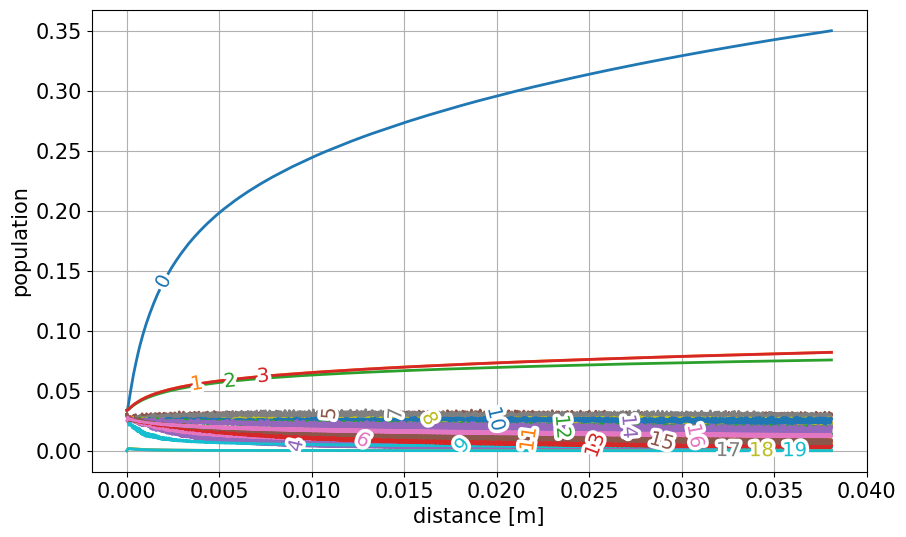

In [45]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, res.y.T, lw=2, label=np.arange(len(res.y)))
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.94 photons


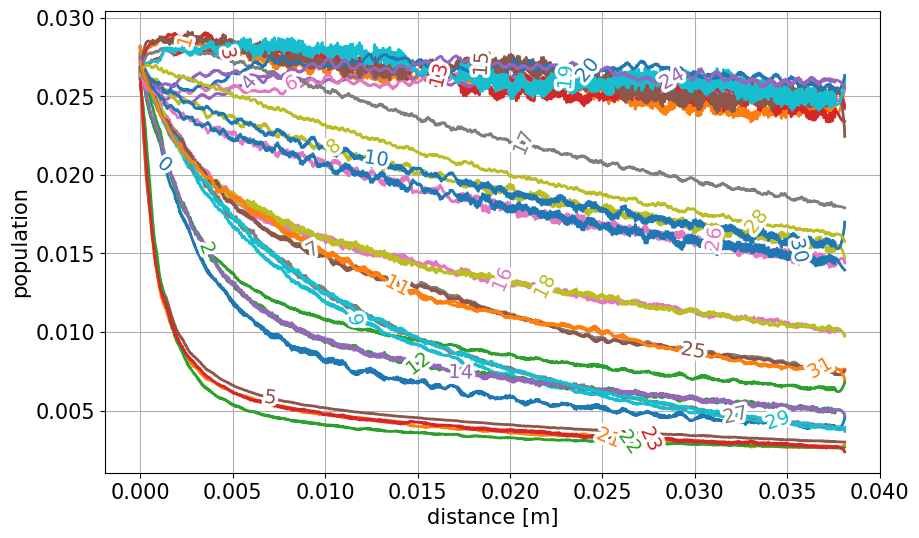

In [46]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]

indices_select = np.append(indices_J1, indices_J2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    res.t * odepars.vz,
    savgol_filter(
        x=results.y[indices_select].T, window_length=201, polyorder=3, axis=0
    ),
    lw=2,
    label=np.arange(len(indices_select)),
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.94 photons


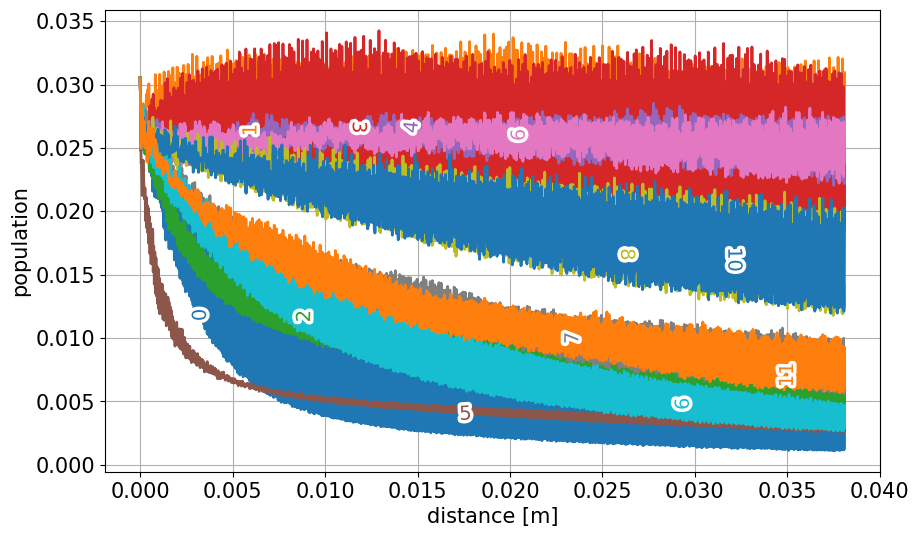

In [47]:
labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]

indices_select = indices_J1

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    res.t * odepars.vz,
    results.y[indices_select].T,
    lw=2,
    label=np.arange(len(indices_select)),
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.94 photons


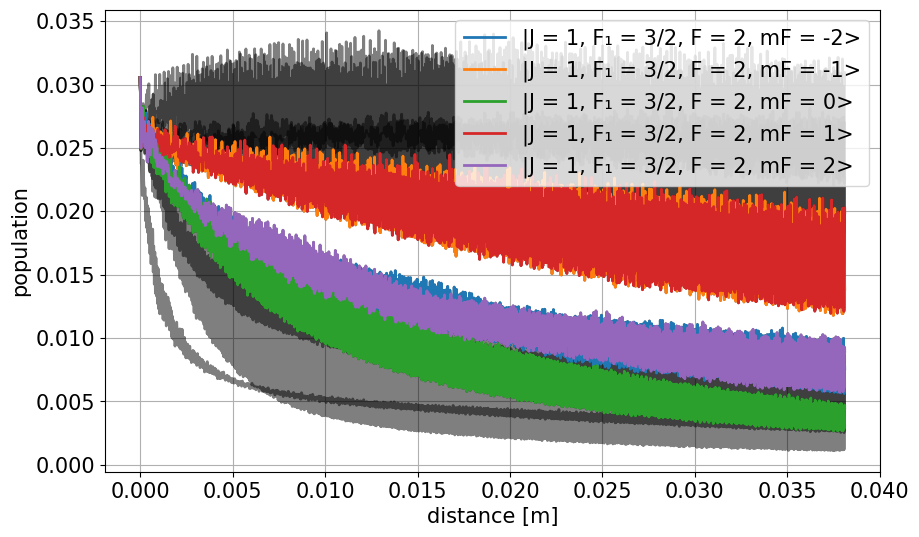

In [48]:
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

labels = [
    f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}" for qn in obe_system.QN
]


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(res.t * odepars.vz, results.y[indices_J1].T, lw=2, alpha=0.5, color="k")

ax.plot(
    res.t * odepars.vz,
    results.y[indices_J1_F2].T,
    lw=2,
    label=np.array(labels)[indices_J1_F2],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.legend()
ax.grid(True)

# labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

0.94 photons


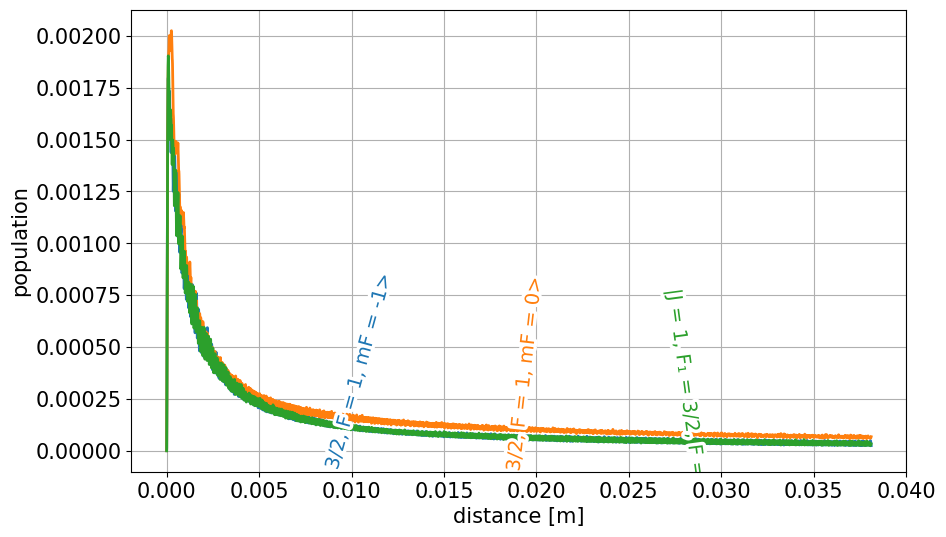

In [49]:
labels = np.array(
    [
        f"{qn.largest.state_string_custom(['J', 'F1', 'F', 'mF'])}"
        for qn in obe_system.QN
    ]
)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    results.t * odepars.vz,
    results.y[indices_excited].T,
    lw=2,
    label=labels[indices_excited],
)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")
ax.grid(True)

labelLines(ax.get_lines(), zorder=2.5, fontsize=14)

nphotons = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")

In [50]:
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [51]:
gain_J0_F1 = (
    results.y[indices_J0_F1].sum(axis=0)[-1] / results.y[indices_J0_F1].sum(axis=0)[0]
)
gain_J0_F0 = (
    results.y[indices_J0_F0].sum(axis=0)[-1] / results.y[indices_J0_F0].sum(axis=0)[0]
)

print(f"gain J=0 F=0 from simulation → {gain_J0_F0:>4.1f}")
print(f"gain J=0 F=1 from simulation → {gain_J0_F1:>4.1f}")

gain J=0 F=0 from simulation → 10.4
gain J=0 F=1 from simulation →  2.4


In [52]:
depletion_J1_F2 = results.y[indices_J1_F2][:, -1] / results.y[indices_J1_F2][:, 0]
print(f"depletion J=1 F=2 from simulation → {depletion_J1_F2.mean():.2f}")

depletion J=1 F=2 from simulation → 0.36


In [53]:
depletion_J1 = results.y[indices_J1][:, -1] / results.y[indices_J1][:, 0]
print(f"depletion J=1 from simulation → {depletion_J1.mean():.2f}")

depletion J=1 from simulation → 0.48


In [54]:
depletion_J1 = results.y[indices_J1][:, -1].sum() / results.y[indices_J1][:, 0].sum()
print(f"depletion J=1 from simulation → {depletion_J1:.2f}")

depletion J=1 from simulation → 0.48


In [55]:
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
depletion_J2_F3 = results.y[indices_J2_F3][:, -1] / results.y[indices_J2_F3][:, 0]
print(f"depletion J=2 F=3 from simulation → {depletion_J2_F3.mean():.2f}")

depletion J=2 F=3 from simulation → 0.36


In [56]:
depletion_J2 = results.y[indices_J2][:, -1] / results.y[indices_J2][:, 0]
print(f"depletion mean J=2 from simulation → {depletion_J2.mean():.2f}")

depletion mean J=2 from simulation → 0.47


In [57]:
depletion_J2 = results.y[indices_J2][:, -1].sum() / results.y[indices_J2][:, 0].sum()
print(f"depletion J=2 from simulation → {depletion_J2:.2f}")

depletion J=2 from simulation → 0.47


In [58]:
br_df = couplings.generate_br_dataframe(
    obe_system.ground, obe_system.excited, group_ground="mF"
)
br_J0_F0, br_J0_F1, *_ = br_df.values.flatten()

In [59]:
def gain_J0_F1_from_depletion(depletion: npt.NDArray[np.float_], T: float) -> float:
    p = thermal_population(J=np.array([0, 1, 2]), T=T)
    population_to_transfer = ((depletion) * p[1:]).sum()
    factor_to_J0_F1 = br_J0_F1 / (br_J0_F1 + br_J0_F0)
    initial_population = p[0] / J_levels(0) * 3
    gain = (
        initial_population + factor_to_J0_F1 * population_to_transfer
    ) / initial_population
    return gain

In [60]:
gain_J0_F1 = gain_J0_F1_from_depletion(np.array([1 - 0.36, 1 - 0.36]), T=6.3)
print(f"gain J=0 F=1 from depletion J=1 F=2 and J=2 F=3 → {gain_J0_F1:.1f}")

gain J=0 F=1 from depletion J=1 F=2 → 2.7


In [61]:
gain_J0_F1 = gain_J0_F1_from_depletion(np.array([1 - 0.47, 1 - 0.47]), T=6.3)
print(f"gain J=0 F=1 from depletion J=1 → {gain_J0_F1:.1f}")

gain J=0 F=1 from depletion J=1 → 2.4


## Ensemble Simulation with temperature, laser and microwave power

In [62]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [63]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.X)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [159]:
from julia import Main


def retrieve_results(solution: str):
    nr_solutions = Main.eval(f"size({solution})")[-1]
    res = np.array(
        [Main.eval(f"{solution}[{ids}][:]") for ids in range(1, nr_solutions + 1)]
    ).real
    return res

In [382]:
rabis_laser = np.linspace(0, 1, 11) * hamiltonian.Γ
rabis_microwave = np.linspace(0, 1, 12) * hamiltonian.Γ
Ts = np.linspace(4, 18, 11)

ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()", save_idxs=save_idxs, save_everystep=False
)


results_temperature_power = []
for T in tqdm.tqdm(Ts):
    ρ = generate_thermal_population_states(
        temperature=T,
        QN=obe_system.QN,
    )
    ρ /= np.trace(ρ)

    problem = lindblad_julia.OBEProblem(
        odepars, ρ, tspan=(0, 25.4e-3 * 1.5 / odepars.vz)
    )

    scan_values = [rabis_laser, rabis_microwave]
    parameters = ["Ωl0", "Ω1"]

    ensemble_problem = lindblad_julia.OBEEnsembleProblem(
        problem=problem,
        parameters=parameters,
        scan_values=scan_values,
    )

    lindblad_julia.setup_problem_parameter_scan(
        ensemble_problem,
    )

    lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

    results = retrieve_results("sol")

    results_temperature_power.append(
        results.reshape(rabis_microwave.size, rabis_laser.size, *results.shape[-2:])
    )

results_temperature_power = np.array(results_temperature_power)

100%|██████████| 11/11 [09:09<00:00, 49.96s/it]


## Fractional population in J=0

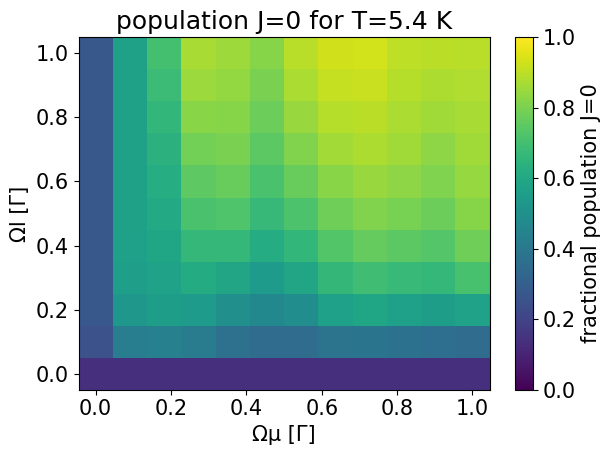

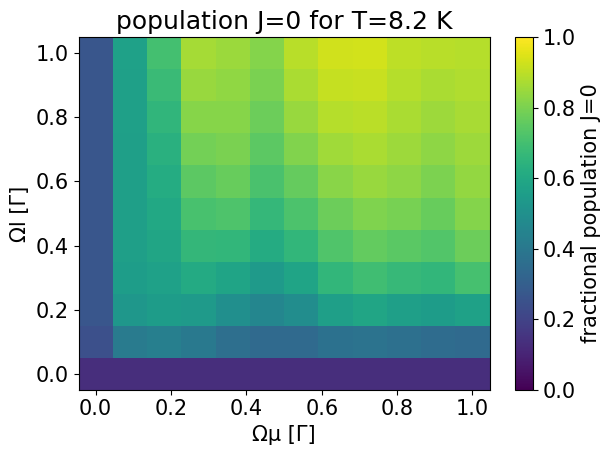

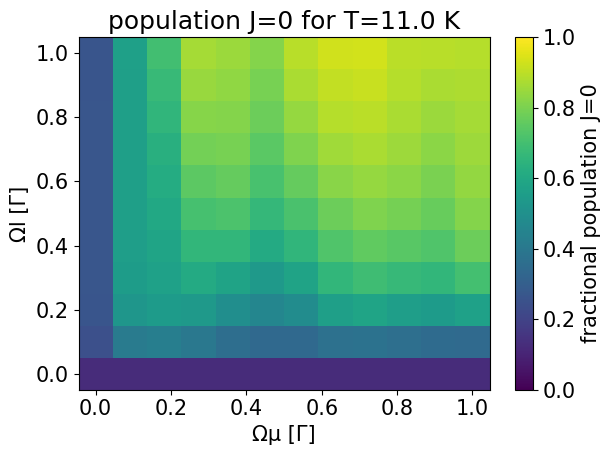

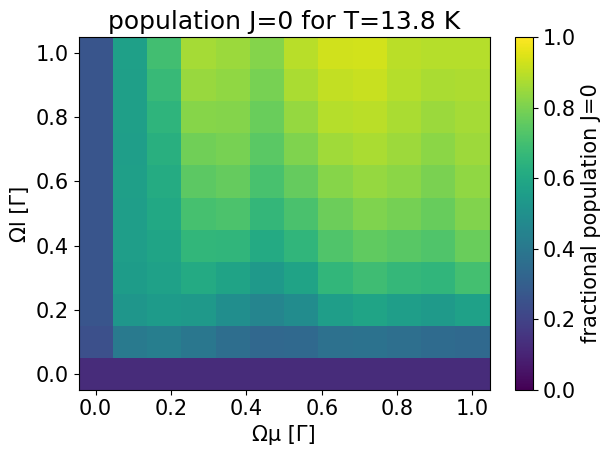

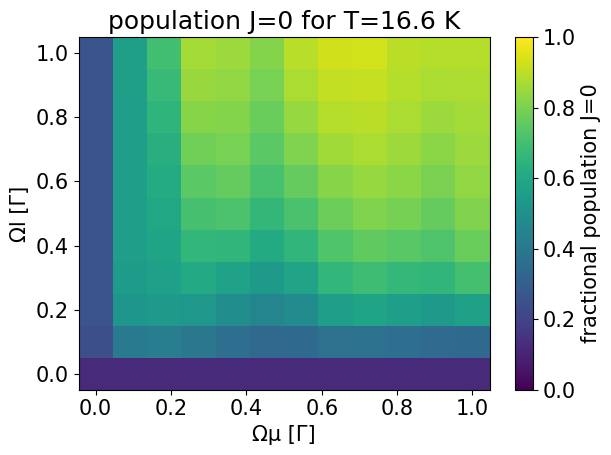

In [454]:
X,Y = np.meshgrid(rabis_microwave, rabis_laser, indexing='ij')

for idT, Ti in enumerate(Ts):
    if idT % 2 == 0:
        continue

    data = results_temperature_power[idT,:,:,-1,:4].sum(axis=-1)

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, data, vmin = 0, vmax = 1)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("fractional population J=0")
    ax.set_xlabel("Ωμ [Γ]")
    ax.set_ylabel("Ωl [Γ]")
    ax.set_title(f"population J=0 for T={Ti:.1f} K")
    fig.tight_layout()
    # ax.grid(True)

In [455]:
depletion_J1_F2 = (results_temperature_power[:, :, :, -1, indices_J1_F2] / results_temperature_power[
    :, :, :, 0, indices_J1_F2
])
depletion_J2_F3 = (results_temperature_power[:, :, :, -1, indices_J2_F3] / results_temperature_power[
    :, :, :, 0, indices_J2_F3
])
depletion_J1 = (results_temperature_power[:, :, :, -1, indices_J1] / results_temperature_power[
    :, :, :, 0, indices_J1
])
depletion_J2 = (results_temperature_power[:, :, :, -1, indices_J2] / results_temperature_power[
    :, :, :, 0, indices_J2
])
gain_J0_F1 = (results_temperature_power[:, :, :, -1, indices_J0_F1] / results_temperature_power[
    :, :, :, 0, indices_J0_F1
])
gain_J0_F0 = (results_temperature_power[:, :, :, -1, indices_J0_F0] / results_temperature_power[
    :, :, :, 0, indices_J0_F0
])

## Gain J=0 F=1

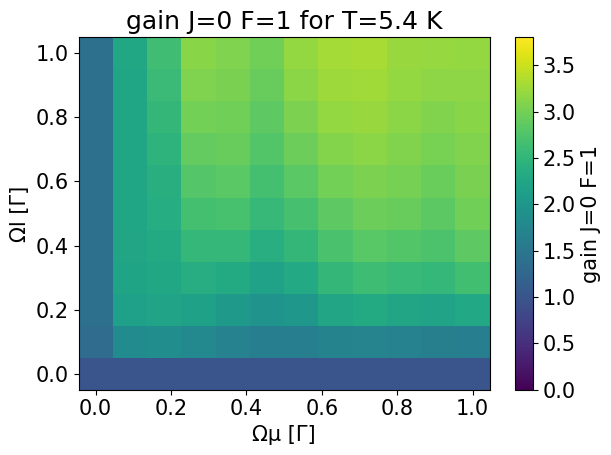

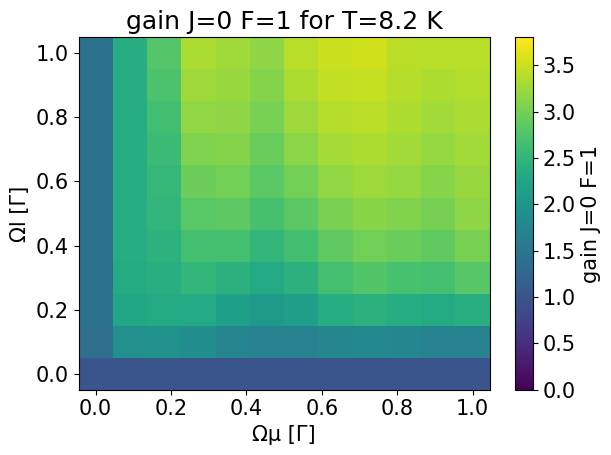

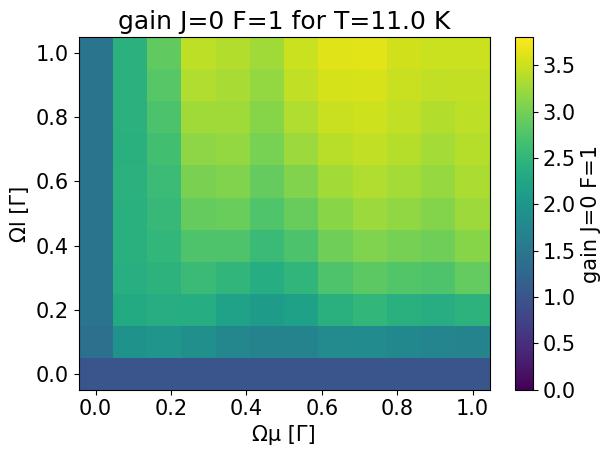

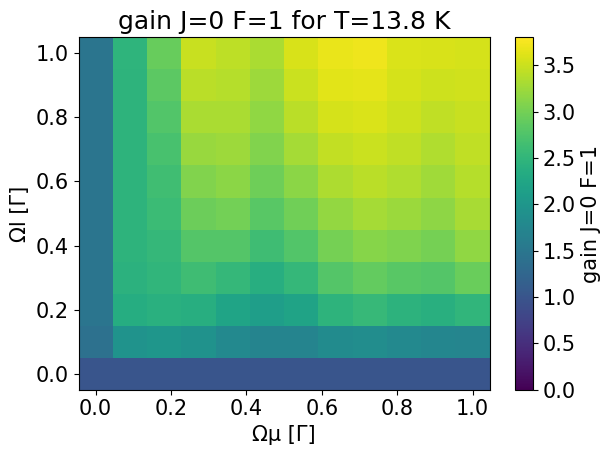

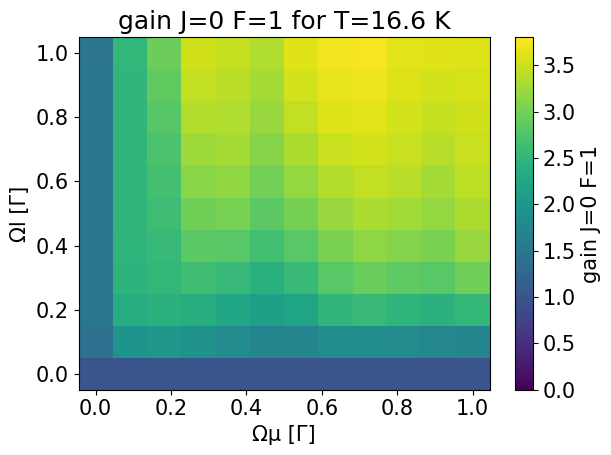

In [456]:
for idT, Ti in enumerate(Ts):
    if idT % 2 == 0:
        continue

    X, Y = np.meshgrid(rabis_microwave, rabis_laser, indexing="ij")

    data = gain_J0_F1.mean(axis=-1)[idT]

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, data, vmin=0, vmax=3.8)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("gain J=0 F=1")
    ax.set_xlabel("Ωμ [Γ]")
    ax.set_ylabel("Ωl [Γ]")
    ax.set_title(f"gain J=0 F=1 for T={Ti:.1f} K")
    fig.tight_layout()
    # ax.grid(True)

## Gain J=0 F=0

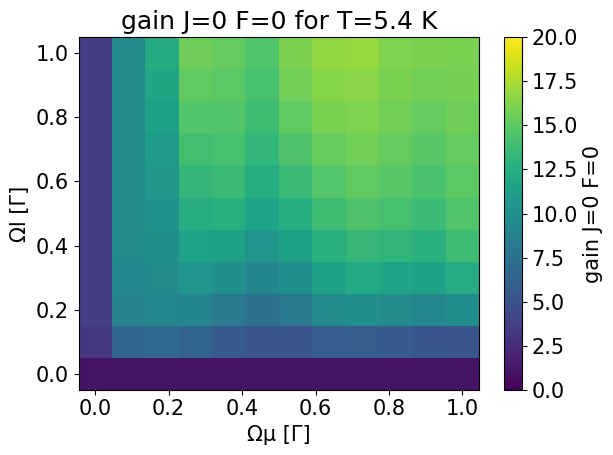

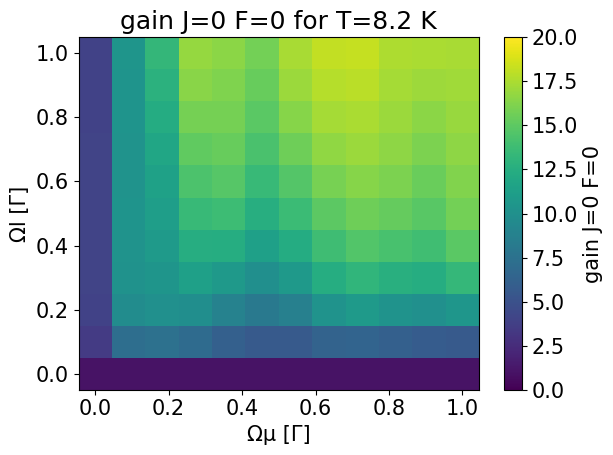

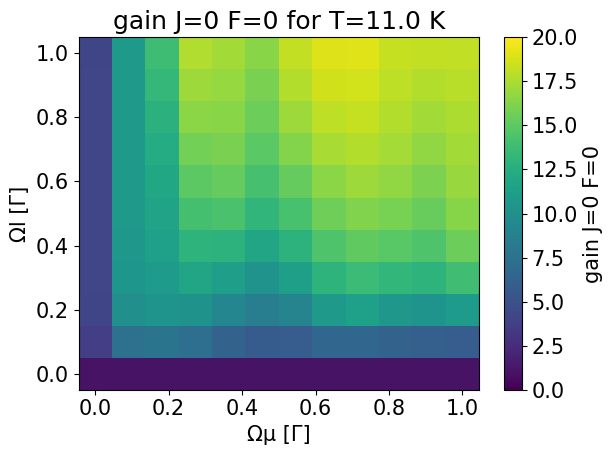

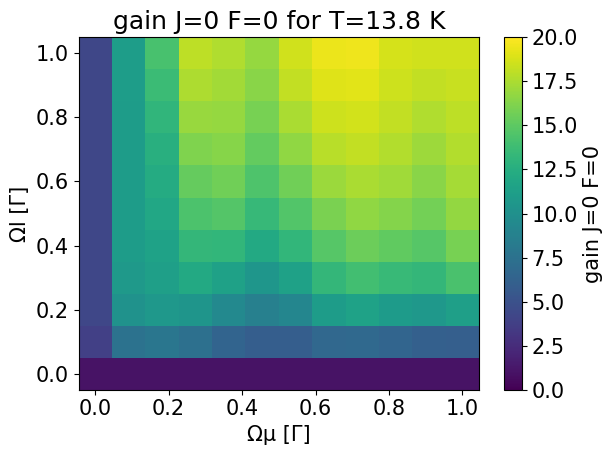

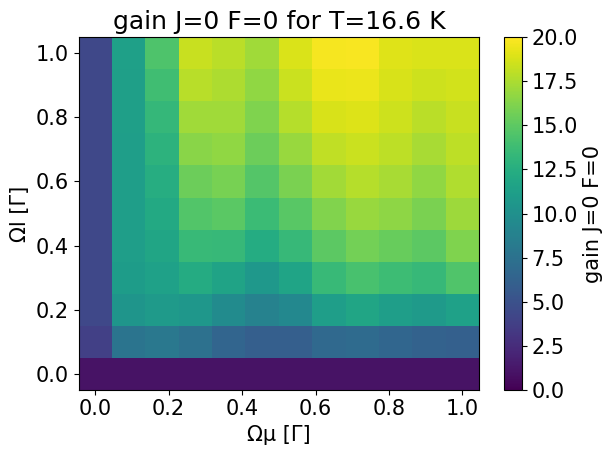

In [457]:
X,Y = np.meshgrid(rabis_microwave, rabis_laser, indexing='ij')

for idT, Ti in enumerate(Ts):
    if idT % 2 == 0:
        continue

    data = gain_J0_F0.mean(axis=-1)[idT]

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(X / hamiltonian.Γ, Y / hamiltonian.Γ, data, vmin = 0, vmax = 20)
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("gain J=0 F=0")
    ax.set_xlabel("Ωμ [Γ]")
    ax.set_ylabel("Ωl [Γ]")
    ax.set_title(f"gain J=0 F=0 for T={Ti:.1f} K")
    fig.tight_layout()
    # ax.grid(True)

## Gain from depletions in J=1, F=2 and J=2, F=3 vs actual gain

In [458]:
import itertools

gain_from_depletion_high_F = np.empty(gain_J0_F1.shape[:-1])

for i, j, k in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.append(
        1 - depletion_J1_F2.mean(axis=-1)[i, j, k],
        1 - depletion_J2_F3.mean(axis=-1)[i, j, k],
    )
    gain_from_depletion_high_F[i, j, k] = gain_J0_F1_from_depletion(
        depletion=dep, T=Ts[i]
    )

gain_from_depletion = np.empty(gain_J0_F1.shape[:-1])

for i, j, k in itertools.product(*[range(v) for v in gain_J0_F1.shape[:-1]]):
    dep = np.append(
        1 - depletion_J1.mean(axis=-1)[i, j, k],
        1 - depletion_J2.mean(axis=-1)[i, j, k],
    )
    gain_from_depletion[i, j, k] = gain_J0_F1_from_depletion(
        depletion=dep, T=Ts[i]
    )

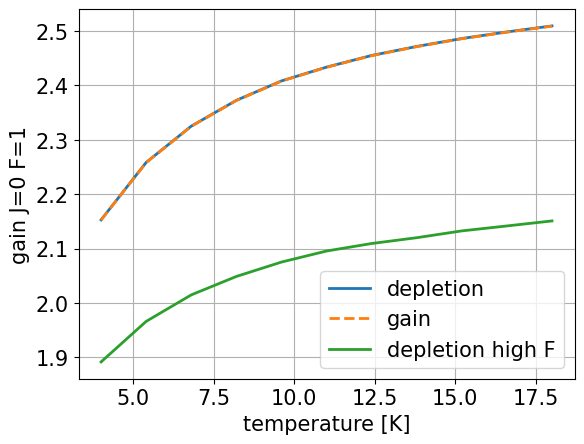

In [459]:
idx_mu, idx_laser = 1, 10
fig, ax = plt.subplots()

ax.plot(Ts, gain_from_depletion[:, idx_mu, idx_laser], label="depletion", lw=2)
ax.plot(
    Ts,
    gain_J0_F1[:, idx_mu, idx_laser].mean(axis=-1),
    label="gain",
    ls="--",
    lw=2,
)
ax.plot(
    Ts,
    gain_from_depletion_high_F[:, idx_mu, idx_laser],
    label="depletion high F",
    lw=2,
)
ax.set_xlabel("temperature [K]")
ax.set_ylabel("gain J=0 F=1")
ax.legend()
ax.grid(True)

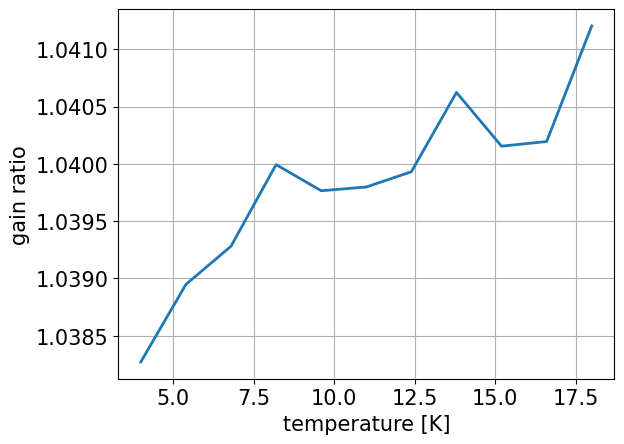

In [460]:
idx_mu, idx_laser = 5, 10
fig, ax = plt.subplots()

ax.plot(
    Ts,
    gain_from_depletion_high_F[:, idx_mu, idx_laser]
    / gain_J0_F1[:, idx_mu, idx_laser].mean(axis=-1),
    lw=2,
)
ax.set_xlabel("temperature [K]")
ax.set_ylabel("gain ratio")
ax.grid(True)

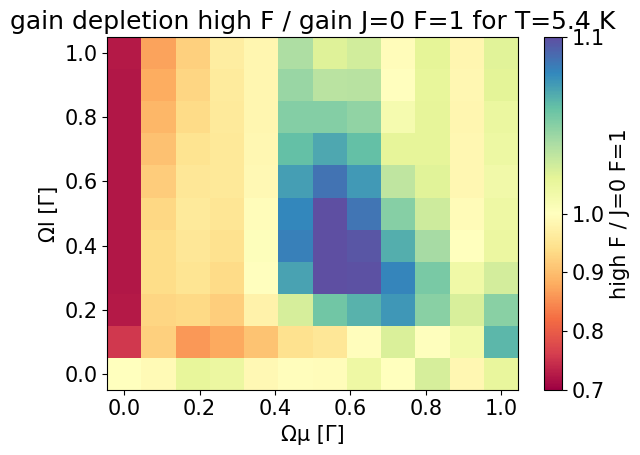

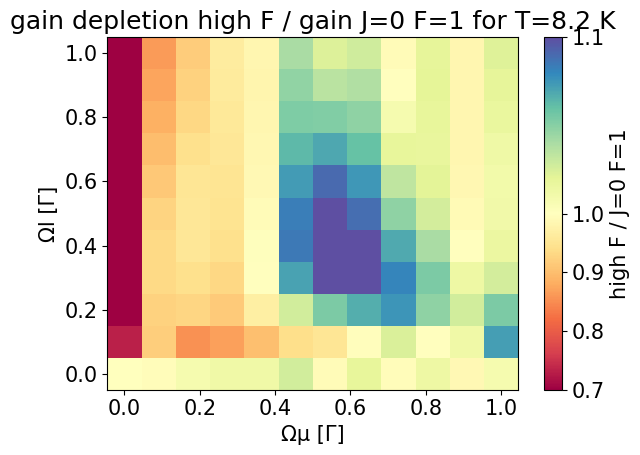

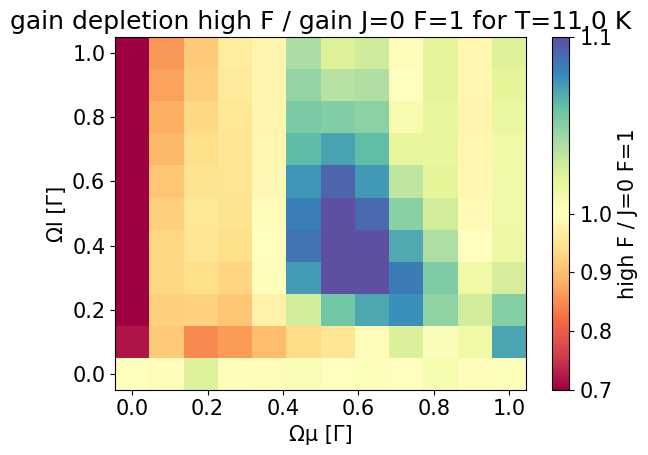

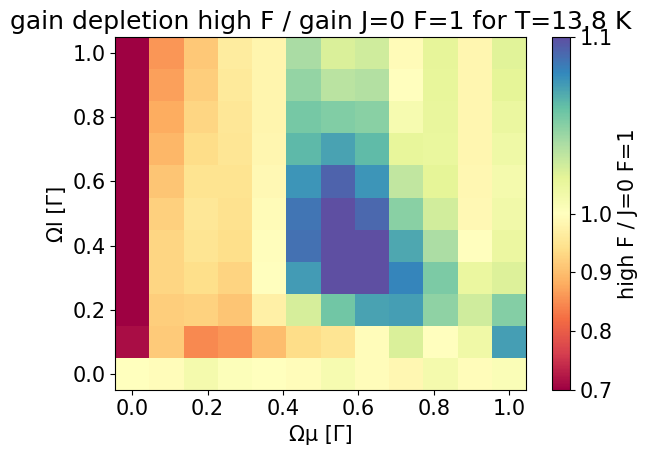

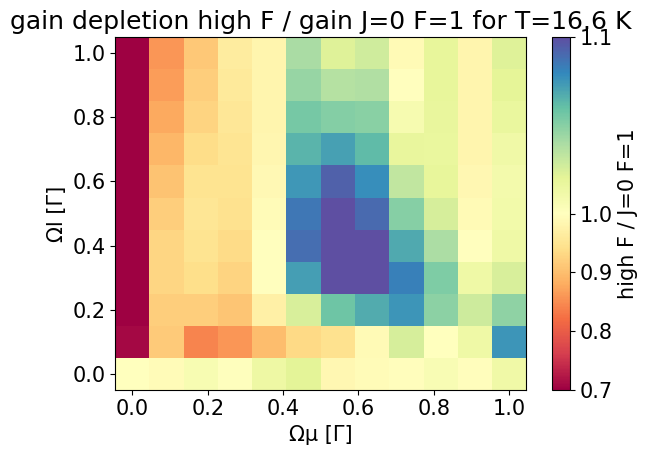

In [461]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.1)

X, Y = np.meshgrid(rabis_microwave, rabis_laser)

for idT, Ti in enumerate(Ts):
    if idT % 2 == 0:
        continue

    fig, ax = plt.subplots()
    cax = ax.pcolormesh(
        X / hamiltonian.Γ,
        Y / hamiltonian.Γ,
        (gain_from_depletion_high_F[idT] / gain_J0_F1[idT].mean(axis=-1)).T,
        norm = divnorm,
        cmap = "Spectral"
    )
    cbar = fig.colorbar(cax)
    cbar.ax.set_ylabel("high F / J=0 F=1")
    ax.set_xlabel("Ωμ [Γ]")
    ax.set_ylabel("Ωl [Γ]")
    ax.set_title(f"gain depletion high F / gain J=0 F=1 for T={Ti:.1f} K")
    fig.tight_layout()
    # ax.grid(True)

Behaviour is the same for all different rotational temperatures tested. For low microwave power the R(1) F=3 and R(2) F=4 transitions lead to an underestimate of the ratio, while for larger powers it leads to an overestimate.